In [1]:
!pip install pymysql

     |████████████████████████████████| 43 kB 705 kB/s eta 0:00:01


In [3]:
import pymysql
import pandas as pd
from shapely import wkt
import geopandas
import matplotlib.pyplot as plt
from pysal.lib import weights
import contextily
import seaborn
from pysal.explore import esda
from splot.esda import plot_moran
from pysal.model import spreg 
import numpy as np
import matplotlib as mpl

In [4]:
def conn(host,port,db):
    db_settings = {
        "host": host,
        "port": port,
        "user": "root",
        "password": "",
        "db": db,
        "charset": "utf8",
        "connect_timeout":31536000
    }

    try:
        conn = pymysql.connect(**db_settings)
        print("success connect to bo!!")
    except Exception as ex:
        conn = None
        print(ex)
    return conn

def query(conn,command):
    with conn.cursor() as cursor:
        cursor.execute(command)
        result = cursor.fetchall()
        return result  

-----
# Contiguity Weights空間相鄰權重矩陣

In [5]:
# 資料庫連線
c = conn("house_bo",3306,"bigobject")

success connect to bo!!


In [6]:
# 取出資料放入dataframe
code02 = pd.DataFrame(query(c,"select * from house.area_code2 where city in ('臺北市','新北市')"))
code02 = code02.set_axis(['code2', 'townid', 'town', 'city_id', 'city','u_id',"area",'y','x','geometry','polygon'], axis=1, inplace=False)
code02.head(3)

,code2,townid,town,city_id,city,u_id,area,y,x,geometry,polygon
0,A6501-05,65000010,板橋區,65000,新北市,5,56593.5443,25.032466,121.476122,MULTIPOLYGON (((121.4760850367192 25.033266967...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...
1,A6501-06,65000010,板橋區,65000,新北市,6,41802.6326,25.032153,121.470141,MULTIPOLYGON (((121.4710964634274 25.032148007...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...
2,A6501-07,65000010,板橋區,65000,新北市,7,49451.5894,25.031605,121.477198,MULTIPOLYGON (((121.4793620134134 25.031974856...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...


In [7]:
# dataframe -> geodataframe
code02['geometry'] = geopandas.GeoSeries.from_wkt(code02['geometry'])
gdf = geopandas.GeoDataFrame(code02, geometry='geometry')

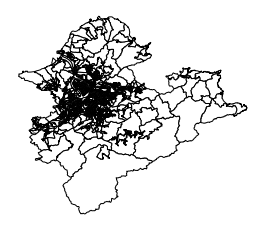

In [8]:
# 畫出邊界
ax = gdf.plot(facecolor='w', edgecolor='k')
ax.set_axis_off()
plt.show()

## 1.Rook:多邊形共用同一個邊

In [9]:
# 空間相鄰矩陣
wr = weights.contiguity.Rook.from_dataframe(gdf)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 11 islands with ids: 327, 830, 1237, 1241, 1288, 1367, 1641, 1647, 1711, 1782, 1830.
  warnings.warn(message)


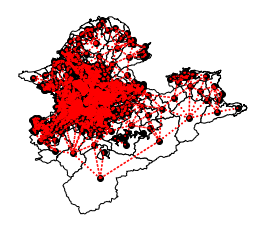

In [10]:
# Set up figure
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
# Plot grid
gdf.plot(facecolor='w', edgecolor='k', ax=ax)

# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
# Remove axes
ax.set_axis_off()

In [11]:
# 計算非0的數量
wr.nonzero

12088

In [12]:
# 次數分配
pd.DataFrame(wr.histogram).head(15)

,0,1
0,0,11
1,1,6
2,2,45
3,3,238
4,4,519
5,5,604
6,6,390
7,7,215
8,8,87
9,9,44


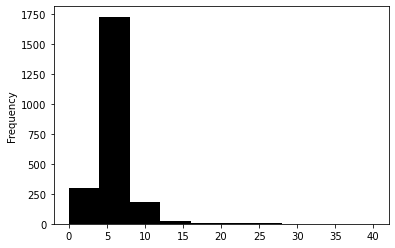

In [13]:
# 繪製直方圖
pd.Series(wr.cardinalities).plot.hist(color='k');

In [14]:
print("連接數："+str(wr.s0))
print("連接密度(連接數/空間數^2 = 40 / 9^2)："+str(round(wr.pct_nonzero,3)))

連接數：12088.0
連接密度(連接數/空間數^2 = 40 / 9^2)：0.239


## 2.Queen:多邊形共用一個或多個點

In [15]:
# 空間相鄰矩陣
wq = weights.contiguity.Queen.from_dataframe(gdf)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 10 islands with ids: 327, 830, 1237, 1288, 1367, 1641, 1647, 1711, 1782, 1830.
  warnings.warn(message)


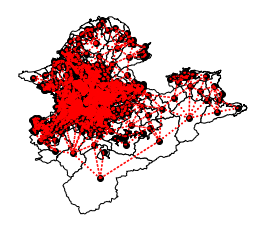

In [16]:
# Set up figure
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
# Plot grid
gdf.plot(facecolor='w', edgecolor='k', ax=ax)

# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
# Remove axes
ax.set_axis_off()

In [17]:
# 計算非0的數量
wq.nonzero

13366

In [18]:
# 次數分配
pd.DataFrame(wq.histogram).head(15)

,0,1
0,0,10
1,1,3
2,2,36
3,3,145
4,4,398
5,5,526
6,6,467
7,7,279
8,8,171
9,9,83


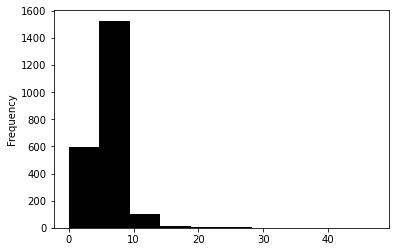

In [19]:
# 繪製直方圖
pd.Series(wq.cardinalities).plot.hist(color='k');

In [20]:
print("連接數："+str(wq.s0))
print("連接密度(連接數/空間數^2 = 40 / 9^2)："+str(round(wq.pct_nonzero,3)))

連接數：13366.0
連接密度(連接數/空間數^2 = 40 / 9^2)：0.264


-----------------
# 預處理

In [21]:
# 資料庫連線
m = conn("house_master",3306,"bigobject")

success connect to bo!!


In [22]:
condition = "city in ('臺北市','新北市') and not transaction_sign in ('車位','土地')  and tgosresaddress <> '找不到指定的門牌地址。' and trans_date <> null and complete_date <> null and complete_date <= trans_date"
period = "'108S1','108S2','108S3','108S4','109S1','109S2','109S3','109S4','110S1','110S2','110S3','110S4'"

In [23]:
# 設定字型
font = mpl.font_manager.FontProperties(fname="./微軟正黑體-1.ttf")
mpl.rcParams['axes.unicode_minus']=False

In [24]:
# 單價分佈(by季)
sql = "select database(),min(unit_price),QUANTILE(unit_price,0.05),QUANTILE(unit_price,0.95),max(unit_price),avg(unit_price),std(unit_price),count(*) from house_buy  where " + condition
sql = "remote "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["period","min_unit_price","qt5","qt95","max_unit_price","avg_unit_price","std_unit_price","count"], axis=1, inplace=False)
data

,period,min_unit_price,qt5,qt95,max_unit_price,avg_unit_price,std_unit_price,count
0,108S1,0,47654.05,242122.80,960615,120861.608891,6.838073e+04,12462
1,108S3,0,49898.10,251041.10,885851,126128.455976,6.852298e+04,14935
2,109S1,0,50568.45,252307.15,1617512,128052.858659,7.155934e+04,14044
3,109S2,0,48853.45,245417.70,2030431,126142.814436,7.054928e+04,13300
4,108S2,0,49579.20,245039.60,1212274,123233.049228,6.752619e+04,13285
5,109S4,0,54462.55,257842.70,1224547,133076.423811,6.971643e+04,17614
6,109S3,0,51033.00,252067.40,1307432,129032.641744,6.866713e+04,21373
7,110S1,0,53821.40,260538.00,1086122,134191.521660,7.196664e+04,14889
8,108S4,0,51267.80,248116.40,2211457,126010.099936,6.925584e+04,14129
9,110S2,0,54809.40,260890.25,1827767,134857.727085,7.044969e+04,17478


In [25]:
# 單價分佈(by季,區)
sql = "select database(),concat(city,town) as area,min(unit_price),QUANTILE(unit_price,0.05),QUANTILE(unit_price,0.95),max(unit_price),avg(unit_price),std(unit_price),count(*) from house_buy "
sql = sql + " where " + condition + " group by area"
sql = "remote "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["period","area","min_unit_price","qt5","qt95","max_unit_price","avg_unit_price","std_unit_price","count"], axis=1, inplace=False)
data

,period,area,min_unit_price,qt5,qt95,max_unit_price,avg_unit_price,std_unit_price,count
0,109S2,臺北市文山區,0,75020.70,210467.10,316677,140691.328947,43475.474892,380
1,109S2,臺北市中正區,11704,106480.20,351869.20,666146,228709.669388,78589.132836,245
2,109S2,臺北市萬華區,0,77399.95,202697.50,369004,143228.104839,45671.223993,248
3,109S2,臺北市大同區,1999,77653.00,254731.00,310345,171082.547511,54226.029344,221
4,109S2,臺北市內湖區,0,86370.90,236406.40,799120,164923.894309,59149.096155,615
...,...,...,...,...,...,...,...,...,...
456,110S4,新北市金山區,25565,32160.50,81789.00,105722,54744.434783,18559.261505,46
457,110S4,新北市雙溪區,31021,32464.90,58455.10,59899,45460.000000,14439.000000,2
458,110S4,新北市貢寮區,19021,19184.15,22120.85,22284,20652.500000,1631.500000,2
459,110S4,新北市石碇區,40863,41763.60,50075.10,50098,46943.333333,4300.461241,3


In [26]:
# 原始資料
sql = "select concat(city,town) as area ,unit_price from house_buy  where " + condition
sql = "cluster "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["area","unit_price"], axis=1, inplace=False)
print("資料筆數:",str(len(data)))
data.head()

資料筆數: 182838


,area,unit_price
0,臺北市文山區,91391
1,臺北市文山區,128417
2,臺北市文山區,328158
3,臺北市文山區,162966
4,臺北市中正區,162201


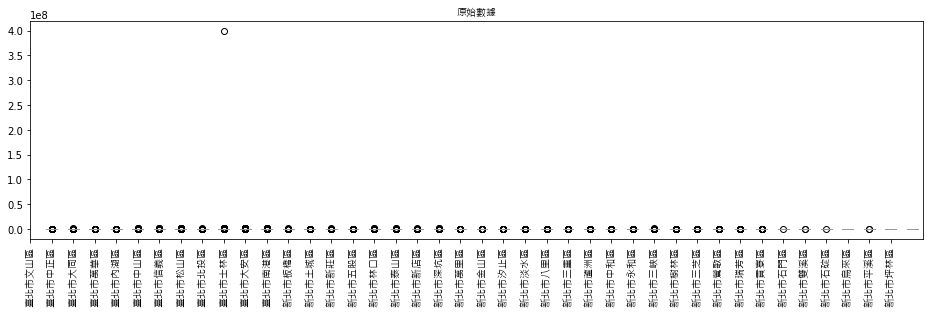

In [27]:
data_2d = []
for i in data['area'].unique():
    data_2d.append(list(data[data['area'] == i]['unit_price']))
plt.figure(figsize=(16,4))
plt.boxplot(data_2d,vert=True)
plt.title("原始數據",fontproperties=font)
plt.xticks(np.arange(len(data['area'].unique())), list(data['area'].unique()), rotation ='vertical',fontproperties=font)
plt.show()

In [28]:
# 截尾平均
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select concat(city,town) as area ,unit_price from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town"
sql = sql + " where " + condition + " and a.unit_price >= b.down_bond and a.unit_price <= b.up_bond"
sql = "cluster "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["area","unit_price"], axis=1, inplace=False)
print("資料筆數:",str(len(data)))
data.head()

資料筆數: 164194


,area,unit_price
0,臺北市文山區,196208
1,臺北市文山區,140761
2,臺北市文山區,139523
3,臺北市中正區,238273
4,臺北市文山區,110504


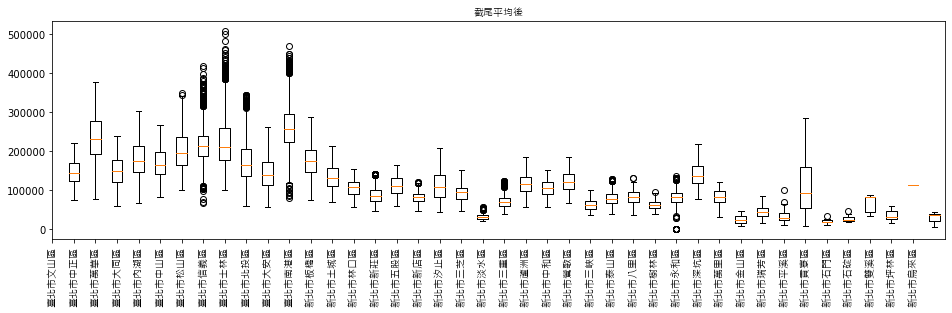

In [29]:
data_2d = []
for i in data['area'].unique():
    data_2d.append(list(data[data['area'] == i]['unit_price']))
plt.figure(figsize=(16,4))
plt.boxplot(data_2d,vert=True)
plt.title("截尾平均後",fontproperties=font)
plt.xticks(np.arange(len(data['area'].unique())), list(data['area'].unique()), rotation ='vertical',fontproperties=font)
plt.show()

In [30]:
# 截尾後單價分佈(by季)
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select database(),min(unit_price),max(unit_price),avg(unit_price),std(unit_price),count(*) from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town "
sql = sql + " where " + condition + " and a.unit_price >= b.down_bond and a.unit_price <= b.up_bond"
sql = "remote "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["period","min_unit_price","max_unit_price","avg_unit_price","std_unit_price","count"], axis=1, inplace=False)
data

,period,min_unit_price,max_unit_price,avg_unit_price,std_unit_price,count
0,110S2,10650,420198,133100.313367,59664.994037,15710
1,108S2,8947,383884,121503.465409,55226.063465,11925
2,109S3,7855,388700,127342.817292,56940.105045,19200
3,109S2,0,508133,124408.133568,56645.165789,11949
4,109S1,9427,482141,126036.362454,57213.576280,12614
5,108S1,8155,469078,118892.461676,55825.842468,11181
6,110S1,10526,500204,132196.776207,59448.475445,13365
7,108S4,4042,433364,124317.242002,55755.274254,12690
8,108S3,13158,427735,124581.330077,57785.714058,13409
9,109S4,8669,450702,131089.195803,58264.906917,15822


In [31]:
# 截尾後單價分佈(by季,區)
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select database(),concat(city,town) as area,min(unit_price),max(unit_price),avg(unit_price),std(unit_price),count(*) from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town "
sql = sql + " where " + condition + " and a.unit_price >= b.down_bond and a.unit_price <= b.up_bond group by area"
sql = "remote "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))
data = data.set_axis(["period","area","min_unit_price","max_unit_price","avg_unit_price","std_unit_price","count"], axis=1, inplace=False)
data

,period,area,min_unit_price,max_unit_price,avg_unit_price,std_unit_price,count
0,108S3,臺北市中正區,125370,331995,226095.791489,50112.637872,235
1,108S3,臺北市文山區,85941,204824,139002.722527,27394.140345,364
2,108S3,臺北市大同區,106980,257150,177526.712707,39924.947345,181
3,108S3,臺北市中山區,124748,300806,200713.144737,45797.879852,684
4,108S3,臺北市內湖區,99103,255040,169496.445364,37257.352275,604
...,...,...,...,...,...,...,...
443,110S4,新北市萬里區,11496,47073,26365.232558,9596.626919,43
444,110S4,新北市瑞芳區,20219,69559,39308.125000,12666.578489,24
445,110S4,新北市金山區,32498,81351,53715.900000,14860.554670,40
446,110S4,新北市石碇區,49869,49869,49869.000000,0.000000,1


In [32]:
def pltfacility(tbl,name):
    sql = "cluster select code2,b.cnt as cnt from area_code2  a left join (select code2,count(*) as cnt from "+tbl+" group by code2) b on a.code2 = b.code2 where city in ('臺北市','新北市')"
    data = pd.DataFrame(query(m,sql))
    data = data.set_axis(["code2","cnt"], axis=1, inplace=False)
    plt.figure(figsize=(4,4))
    plt.hist(data["cnt"])
    plt.title(name,fontproperties=font)
    plt.show()    

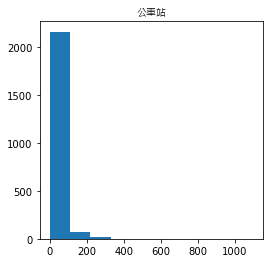

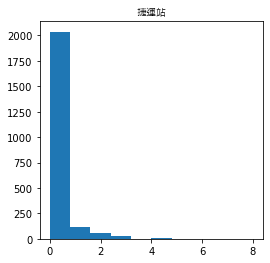

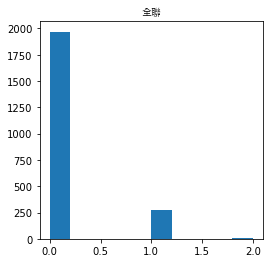

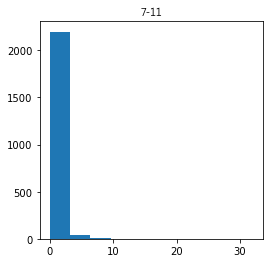

In [33]:
pltfacility("busstation","公車站")
pltfacility("mrtstation","捷運站")
pltfacility("pxmart","全聯")
pltfacility("shopseven","7-11")

-----------------
# 敘述統計

In [34]:
# 資料庫連線
m = conn("house_master",3306,"bigobject")

success connect to bo!!


In [35]:
house_var = [
    'unit_price * 1.00 / 10000 as unit_price_w',  #y單價
    'area',            #x1土地移轉總面積平方公尺
    'year(trans_date) - year(complete_date) as age',     
                       #x2屋齡
    'shifting_area',   #x3建物移轉總面積平方公尺
    'pattern_room',    #x4建物現況格局-房
    'pattern_hall',    #x5建物現況格局-廳
    'pattern_health',  #x6建物現況格局-衛
    'building_area'    #x7主建物面積
]

In [36]:
other_var = [
    'mrtstation',           #x8臺北捷運車站
    'busstation',           #x9公車站
    'tymetrostation',       #x10機場捷運
    'shopfamily + shophilife + shopokmart + shopseven as store',
                            #x11便利商店(全家+7-11+萊爾富+ok)
    'simplemart',           #x12美廉社
    'pxmart',               #x13全聯
    'carrefour',            #x14家樂福
    'costco',               #x15Costco
    'rtmart',               #x16大潤發
    'pharmarcy',            #x17藥局
    'policestation',        #x18警察局/派出所
    'firestation',          #x19消防隊
    'hospital',             #x20醫療院所
    'school',               #x21學校
    'airport',              #x22民用航空站服務台
    'incinerator',          #x23焚化廠
    'cleaningteam',         #x24全國各縣市清潔隊
    'cleaninginstitution',  #x25公民營廢棄物清除機構
    'recyclablesdepot',     #x26資源回收業
    'radio',                #x27電臺發射機
    'nuclear_powerplant',   #x28核能發電廠
    'gas_station',          #x29加油站
                            #x30營運中工廠家數
    'funeralfacilities',    #x31殯葬設施
    'temple',               #x32寺廟
    'ancestralhall',        #x33宗祠
    'foundation',           #x34宗祠基金會
    'incineratorarea',      #x35焚化爐
    'wastewater',            #x36工業汙水處理
    'waste',                #x37回收廢棄物處理業者
    'powerplant',           #x38發電廠
    'lpg',                  #x39液化石油氣分裝業
                            #x40殯葬禮儀服務業商業登記數量
                            #x41殯葬禮儀服務業公司登記數量
]

In [37]:
house_var_n = [v.split(" as ")[1] if " as " in v else v for v in house_var]
other_var_n = [v.split(" as ")[1] if " as " in v else v for v in other_var]

In [38]:
sql = "select city,town,QUANTILE(unit_price,0.05) as down_bond,QUANTILE(unit_price,0.95) as up_bond from house_buy where " + condition + " group by city,town"
sql = "select code2,"+",".join(house_var) + " from house_buy a inner join ("+sql+") b on a.city = b.city and a.town = b.town "
sql = sql + " where " + condition + " and a.unit_price >= b.down_bond and a.unit_price <= b.up_bond"
sql = "select code2,{} from ({}) group by code2".format(",".join(["avg("+v+") as "+v for v in house_var_n]),sql)
sql = "select code2,{},{},c.geometry as geometry from ({}) a left join (select code2,{} from unified.code2) b on a.code2 = b.code2 inner join house.area_code2 c on a.code2 = c.code2".format(",".join(["a."+v+" as "+v for v in house_var_n]),",".join(["b."+v+" as "+v for v in other_var_n]),sql,','.join(other_var))
sql = "cluster "+ sql + " partition by db in ("+period+")"
data = pd.DataFrame(query(m,sql))

In [39]:
data = data.set_axis(['code2']+house_var_n+other_var_n+['geometry'], axis=1, inplace=False)
data['geometry'] = geopandas.GeoSeries.from_wkt(data['geometry'])
data.head()

,code2,unit_price_w,area,age,shifting_area,pattern_room,pattern_hall,pattern_health,building_area,mrtstation,...,funeralfacilities,temple,ancestralhall,foundation,incineratorarea,wastewater,waste,powerplant,lpg,geometry
0,A6308-51,19.143744,13.041111,24.333333,77.248889,1.777778,1.000000,1.222222,49.778889,2,...,0,1,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.54230 24.99499, 121.54232 ..."
1,A6308-62,16.243189,14.431111,8.111111,175.560000,2.222222,1.333333,1.444444,84.160000,0,...,0,1,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.57079 24.98994, 121.57068 ..."
2,A6308-02,15.719300,25.983333,37.333333,106.156667,2.666667,2.000000,1.666667,83.593333,0,...,0,1,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.53759 25.00713, 121.53748 ..."
3,A6305-41,20.872850,11.905000,20.000000,154.850000,2.333333,1.333333,1.333333,104.143333,3,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.52339 25.02577, 121.52357 ..."
4,A6308-25,13.397433,41.666667,29.500000,94.301667,2.166667,1.666667,1.333333,62.051667,1,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.57192 25.00204, 121.57195 ..."


In [40]:
# 描述性統計
data.describe().T

,count,mean,std,min,25%,50%,75%,max
unit_price_w,24553.0,13.610783,5.072410,1.1221,9.702650,11.944129,17.557800,42.7172
area,24553.0,30.731357,264.821085,0.0000,18.312000,23.350000,30.205000,40626.3300
age,24553.0,22.130977,9.916919,0.0000,15.400000,21.625000,28.333333,63.0000
shifting_area,24553.0,137.103932,175.319579,9.8800,100.040000,124.075000,151.390000,17418.6100
pattern_room,24553.0,2.552702,0.887702,0.0000,2.000000,2.545455,3.000000,54.0000
pattern_hall,24553.0,1.622272,0.458901,0.0000,1.400000,1.666667,2.000000,23.0000
pattern_health,24553.0,1.592254,0.643864,0.0000,1.285714,1.500000,1.909091,45.0000
building_area,24553.0,85.730657,81.551150,0.0000,66.022500,78.392500,93.000000,7472.7075
mrtstation,24553.0,0.178186,0.660512,0.0000,0.000000,0.000000,0.000000,8.0000
busstation,24553.0,25.209791,46.471473,0.0000,4.000000,13.000000,29.000000,1096.0000


--------
# Non-spatial regression

In [41]:
dep_var = 'unit_price_w'
ind_var = []
for v in house_var_n:
    if v != dep_var:
        ind_var.append(v)
ind_var = ind_var + other_var_n

In [42]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    data[[dep_var]].values, 
    # Independent variables
    data[ind_var].values,
    # Dependent variable name
    name_y=dep_var, 
    # Independent variable name
    name_x=ind_var
)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :unit_price_w                Number of Observations:       24553
Mean dependent var  :     13.6108                Number of Variables   :          37
S.D. dependent var  :      5.0724                Degrees of Freedom    :       24516
R-squared           :      0.1687
Adjusted R-squared  :      0.1674
Sum squared residual:  525163.854                F-statistic           :    138.1584
Sigma-square        :      21.421                Prob(F-statistic)     :           0
S.E. of regression  :       4.628                Log likelihood        :  -72440.598
Sigma-square ML     :      21.389                Akaike info criterion :  144955.197
S.E of regression ML:      4.6248                Schwarz criterion     :  145255.214

-----------------------------------------------------------------------------

-----------------
# Spatial Autocorrelation空間自相關

In [43]:
data['residual'] = m1.u

In [44]:
db = geopandas.GeoDataFrame(data)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24553 entries, 0 to 24552
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   code2                24553 non-null  object  
 1   unit_price_w         24553 non-null  float64 
 2   area                 24553 non-null  float64 
 3   age                  24553 non-null  float64 
 4   shifting_area        24553 non-null  float64 
 5   pattern_room         24553 non-null  float64 
 6   pattern_hall         24553 non-null  float64 
 7   pattern_health       24553 non-null  float64 
 8   building_area        24553 non-null  float64 
 9   mrtstation           24553 non-null  int64   
 10  busstation           24553 non-null  int64   
 11  tymetrostation       24553 non-null  int64   
 12  store                24553 non-null  int64   
 13  simplemart           24553 non-null  int64   
 14  pxmart               24553 non-null  int64   
 15  carrefour  

In [45]:
w = weights.contiguity.Rook.from_dataframe(db)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


## 檢驗房屋單價
### 1.Global Autocorrelation

/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


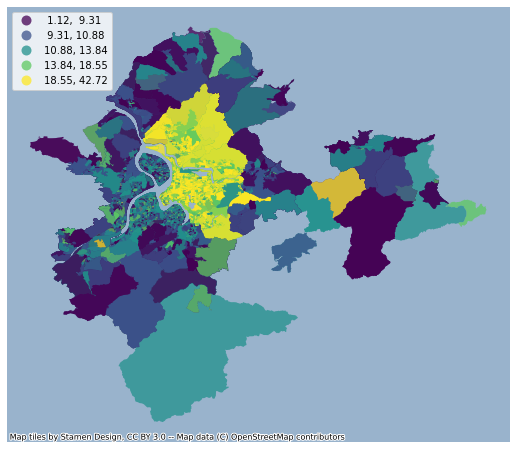

In [46]:
# 單價繪圖
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='unit_price_w', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax)
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

In [47]:
# spatial_lag
db['unit_price_lag'] = weights.spatial_lag.lag_spatial(w, db['unit_price_w'])
db.head()

,code2,unit_price_w,area,age,shifting_area,pattern_room,pattern_hall,pattern_health,building_area,mrtstation,...,ancestralhall,foundation,incineratorarea,wastewater,waste,powerplant,lpg,geometry,residual,unit_price_lag
0,A6308-51,19.143744,13.041111,24.333333,77.248889,1.777778,1.000000,1.222222,49.778889,2,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.54230 24.99499, 121.54232 ...",1.628680,1327.759908
1,A6308-62,16.243189,14.431111,8.111111,175.560000,2.222222,1.333333,1.444444,84.160000,0,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.57079 24.98994, 121.57068 ...",3.666901,1272.109289
2,A6308-02,15.719300,25.983333,37.333333,106.156667,2.666667,2.000000,1.666667,83.593333,0,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.53759 25.00713, 121.53748 ...",0.933585,1053.625947
3,A6305-41,20.872850,11.905000,20.000000,154.850000,2.333333,1.333333,1.333333,104.143333,3,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.52339 25.02577, 121.52357 ...",1.784385,2167.532432
4,A6308-25,13.397433,41.666667,29.500000,94.301667,2.166667,1.666667,1.333333,62.051667,1,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((121.57192 25.00204, 121.57195 ...",-1.835302,1348.683040


/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


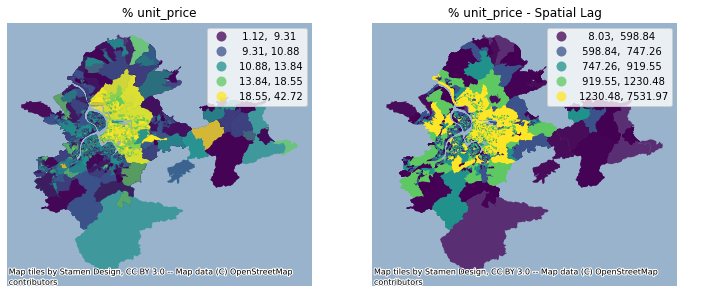

In [48]:
# spatial lag繪圖
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(column='unit_price_w', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("% unit_price")
contextily.add_basemap(ax1, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

db.plot(column='unit_price_lag', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("% unit_price - Spatial Lag")
contextily.add_basemap(ax2, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

plt.show()

In [49]:
# 單價和單價lag標準化
db['unit_price_std'] = (db['unit_price_w'] - db['unit_price_w'].mean()) / db['unit_price_w'].std()
db['unit_price_lag_std'] = ( db['unit_price_lag'] - db['unit_price_lag'].mean()) / db['unit_price_lag'].std()

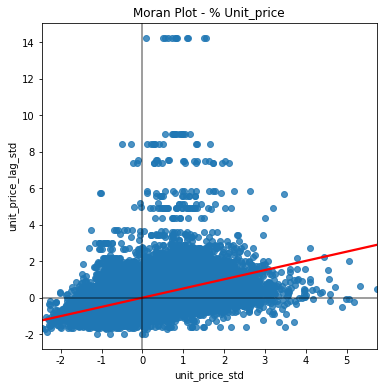

In [50]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(x='unit_price_std', y='unit_price_lag_std', 
                ci=None, data=db, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Unit_price')
plt.show()

In [51]:
# 計算moran's i
moran = esda.moran.Moran(db['unit_price_w'], w)
moran.I

0.6905094762732675

In [52]:
# empirical p-value:夠小的p-vale允許拒絕地圖是隨機的假設
moran.p_sim

0.001

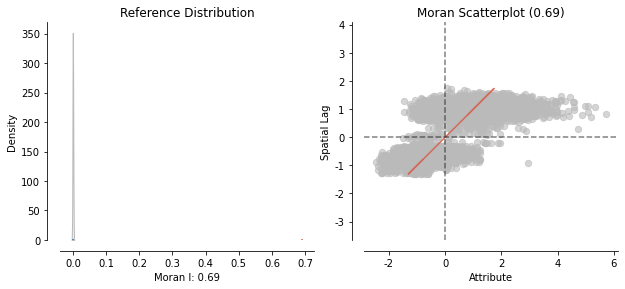

In [53]:
plot_moran(moran);

### 2.Local Autocorrelation

In [54]:
db['w_unit_price_std'] = ( db['unit_price_lag'] - db['unit_price_w'].mean() ) / db['unit_price_w'].std()

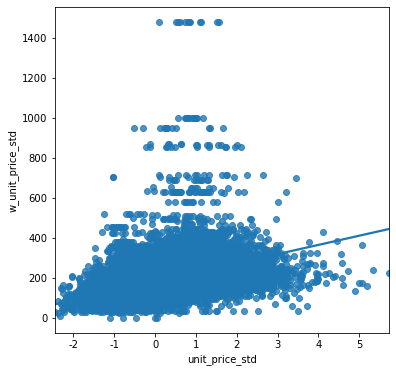

In [55]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='unit_price_std', y='w_unit_price_std', data=db, ci=None)
# Display
plt.show()

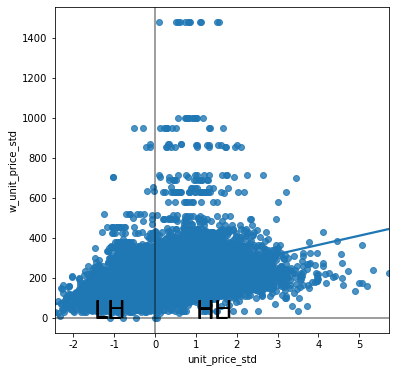

In [56]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='unit_price_std', y='w_unit_price_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [57]:
# 計算LISA(因為有孤島所以沒辦法算)
lisa = esda.moran.Moran_Local(db['unit_price_w'], w)

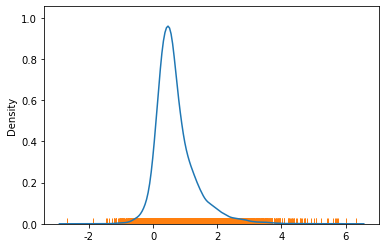

In [58]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

## 檢驗殘差
### 1.Global Autocorrelation

/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


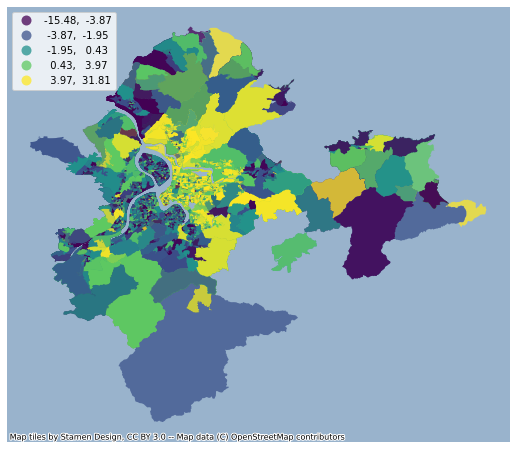

In [59]:
# 殘差繪圖
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='residual', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax)
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

In [60]:
# spatial_lag
db['residual_lag'] = weights.spatial_lag.lag_spatial(w, db['residual'])
db.head()

,code2,unit_price_w,area,age,shifting_area,pattern_room,pattern_hall,pattern_health,building_area,mrtstation,...,waste,powerplant,lpg,geometry,residual,unit_price_lag,unit_price_std,unit_price_lag_std,w_unit_price_std,residual_lag
0,A6308-51,19.143744,13.041111,24.333333,77.248889,1.777778,1.000000,1.222222,49.778889,2,...,0,0,0,"MULTIPOLYGON (((121.54230 24.99499, 121.54232 ...",1.628680,1327.759908,1.090795,0.858251,259.077858,2.264222
1,A6308-62,16.243189,14.431111,8.111111,175.560000,2.222222,1.333333,1.444444,84.160000,0,...,0,0,0,"MULTIPOLYGON (((121.57079 24.98994, 121.57068 ...",3.666901,1272.109289,0.518966,0.737970,248.106620,4.816371
2,A6308-02,15.719300,25.983333,37.333333,106.156667,2.666667,2.000000,1.666667,83.593333,0,...,0,0,0,"MULTIPOLYGON (((121.53759 25.00713, 121.53748 ...",0.933585,1053.625947,0.415684,0.265749,205.033733,2.396270
3,A6305-41,20.872850,11.905000,20.000000,154.850000,2.333333,1.333333,1.333333,104.143333,3,...,0,0,0,"MULTIPOLYGON (((121.52339 25.02577, 121.52357 ...",1.784385,2167.532432,1.431680,2.673301,424.634767,3.396758
4,A6308-25,13.397433,41.666667,29.500000,94.301667,2.166667,1.666667,1.333333,62.051667,1,...,0,0,0,"MULTIPOLYGON (((121.57192 25.00204, 121.57195 ...",-1.835302,1348.683040,-0.042061,0.903473,263.202748,2.002184


/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


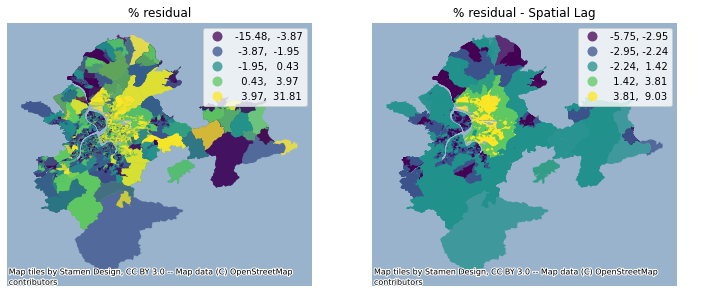

In [61]:
# spatial lag繪圖
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(column='residual', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("% residual")
contextily.add_basemap(ax1, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

db.plot(column='residual_lag', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("% residual - Spatial Lag")
contextily.add_basemap(ax2, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

plt.show()

In [62]:
# 單價和單價lag標準化
db['residual_std'] = (db['residual'] - db['residual'].mean()) / db['residual'].std()
db['residual_lag_std'] = ( db['residual_lag'] - db['residual_lag'].mean()) / db['residual_lag'].std()

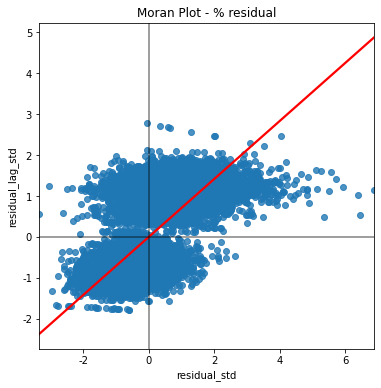

In [63]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(x='residual_std', y='residual_lag_std', 
                ci=None, data=db, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % residual')
plt.show()

In [64]:
# 計算moran's i
moran = esda.moran.Moran(db['residual'], w)
moran.I

0.4964525485231118

In [65]:
# empirical p-value:夠小的p-vale允許拒絕地圖是隨機的假設
moran.p_sim

0.001

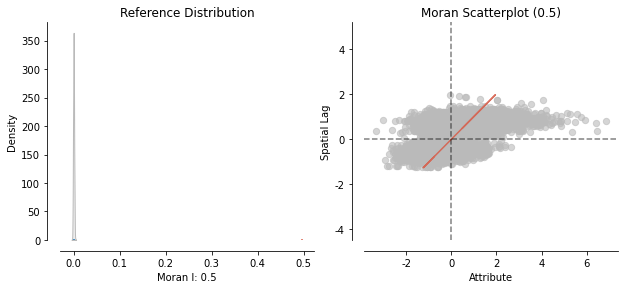

In [66]:
plot_moran(moran);

### 2.Local Autocorrelation

In [67]:
db['w_residual_std'] = ( db['residual_lag'] - db['residual'].mean() ) / db['residual'].std()

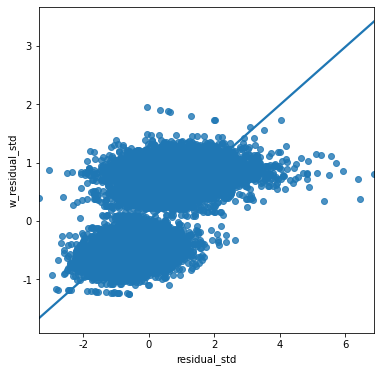

In [68]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='residual_std', y='w_residual_std', data=db, ci=None)
# Display
plt.show()

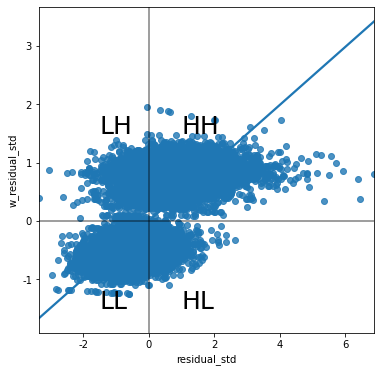

In [69]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='residual_std', y='w_residual_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [70]:
# 計算LISA(因為有孤島所以沒辦法算)
lisa = esda.moran.Moran_Local(db['residual'], w)

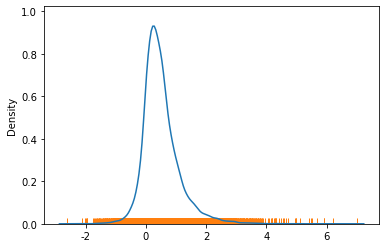

In [71]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

-----------------
# 空間延遲模型(spatial lag model, SLM)

In [72]:
# Fit spatial lag model with `spreg` 
# (GMM estimation)
m2 = spreg.GM_Lag(
    # Dependent variable
    db[[dep_var]].values, 
    # Independent variables
    db[ind_var].values,
    # Spatial weights matrix
    w=w, 
    # Dependent variable name
    name_y=dep_var, 
    # Independent variables names
    name_x=ind_var
)

In [73]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :unit_price_w                Number of Observations:       24553
Mean dependent var  :     13.6108                Number of Variables   :          38
S.D. dependent var  :      5.0724                Degrees of Freedom    :       24515
Pseudo R-squared    :      0.7051
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       1.4331201       0.1094901      13.0890341       0.0000000
                area       0.0004307       0.0000675       6.3817668       0.0000000
                 ag

In [74]:
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m2.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m2.z_stat]
    },
    index=m2.name_z
# Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,1.4331,0.1095,0.0000
area,0.0004,0.0001,0.0000
age,-0.0577,0.0020,0.0000
shifting_area,-0.0007,0.0001,0.0000
pattern_room,-0.2959,0.0359,0.0000
pattern_hall,-0.1550,0.0481,0.0013
pattern_health,0.2261,0.0446,0.0000
building_area,0.0002,0.0003,0.5159
mrtstation,0.0518,0.0310,0.0943
busstation,0.0015,0.0006,0.0096


------
# 空間誤差模型(spatial error model, SEM)

In [75]:
# Fit spatial error model with `spreg` 
# (GMM estimation allowing for heteroskedasticity)
m3 = spreg.GM_Error_Het(
    # Dependent variable
    db[[dep_var]].values, 
    # Independent variables
    db[ind_var].values,
    # Spatial weights matrix
    w=w, 
    # Dependent variable name
    name_y=dep_var, 
    # Independent variables names
    name_x=ind_var
)

In [76]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :unit_price_w                Number of Observations:       24553
Mean dependent var  :     13.6108                Number of Variables   :          37
S.D. dependent var  :      5.0724                Degrees of Freedom    :       24516
Pseudo R-squared    :      0.0002
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      15.6250480       0.3210924      48.6621620       0.0000000
                area       0.0004147       0.0000686       6.0455857       0.00

In [77]:
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m3.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m3.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m3.z_stat]
    },
    index=m3.name_x
# Subset for lambda parameter and round to
# four decimals
).reindex(['lambda']).round(4)

,Coeff.,Std. Error,P-Value
lambda,0.9397,0.0034,0.0
